In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Load the data

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

In [3]:
DATADIR = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
CATEGORIES = ['lung_aca','lung_n','lung_scc']

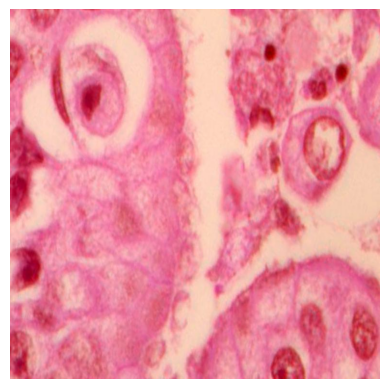

In [4]:
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(img_array)
        plt.axis('off')
        break
    break

In [5]:
img_array

array([[[223, 100, 132],
        [229, 106, 138],
        [234, 115, 144],
        ...,
        [238, 149, 145],
        [241, 157, 151],
        [246, 165, 157]],

       [[225, 100, 132],
        [228, 105, 137],
        [234, 111, 143],
        ...,
        [236, 147, 143],
        [238, 154, 148],
        [242, 161, 153]],

       [[227,  99, 134],
        [229, 103, 138],
        [234, 108, 143],
        ...,
        [231, 144, 140],
        [232, 151, 144],
        [235, 156, 147]],

       ...,

       [[235, 150, 158],
        [235, 150, 158],
        [235, 150, 158],
        ...,
        [234, 151, 160],
        [232, 147, 161],
        [232, 147, 161]],

       [[236, 154, 159],
        [236, 154, 159],
        [236, 154, 159],
        ...,
        [234, 151, 160],
        [232, 147, 161],
        [231, 146, 160]],

       [[237, 155, 160],
        [237, 155, 160],
        [237, 155, 160],
        ...,
        [234, 151, 160],
        [232, 147, 161],
        [231, 146, 160]]

In [6]:
img_array.shape

(768, 768, 3)

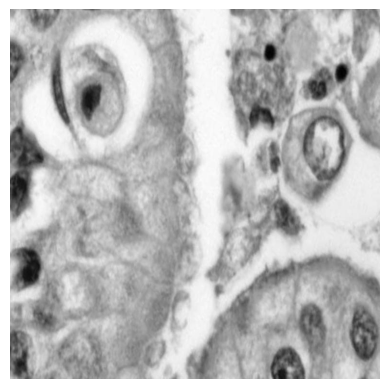

In [7]:
# Lets change the color to gray, in order to decrease the memory usage

for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap = 'gray')
        plt.axis('off')
        break
    break

In [8]:
img_array

array([[124, 130, 137, ..., 158, 165, 172],
       [124, 129, 135, ..., 156, 162, 168],
       [124, 128, 133, ..., 153, 158, 162],
       ...,
       [162, 162, 162, ..., 163, 161, 161],
       [165, 165, 165, ..., 163, 161, 160],
       [166, 166, 166, ..., 163, 161, 160]], dtype=uint8)

In [9]:
img_array.shape

(768, 768)

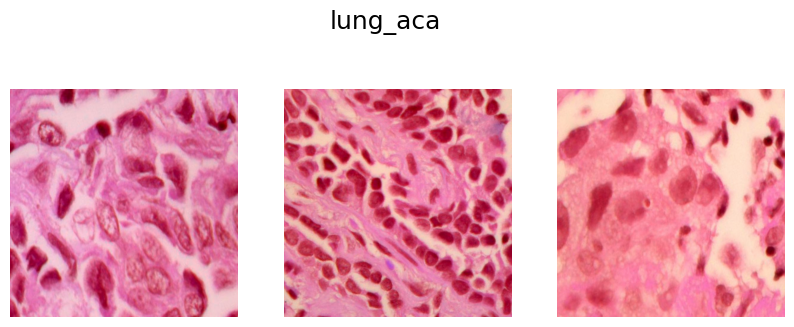

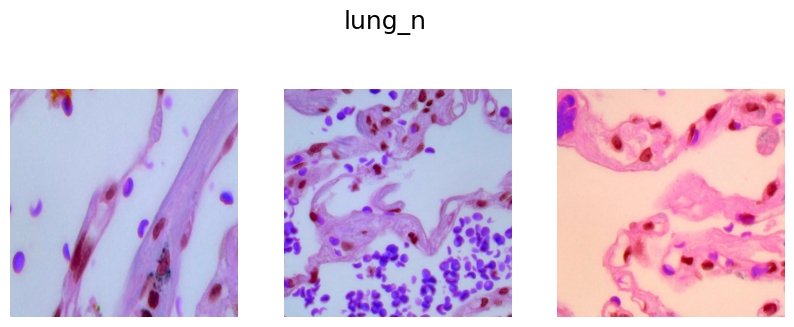

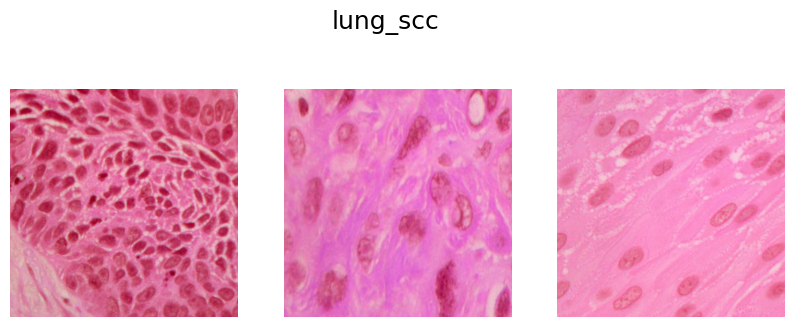

In [10]:
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    images = os.listdir(path)

    fig, ax = plt.subplots(1, 3, figsize = (10, 4))
    fig.suptitle(f'{category}', fontsize=18)

    for i in range(3):
        img_name = images[np.random.randint (0, len(images))]
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path)

        ax[i].imshow(img_array)
        ax[i].axis('off')

## Resize the images

In [11]:
IMG_SIZE = 224 # Because VGG16 takes the image of 224*244 pixels
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

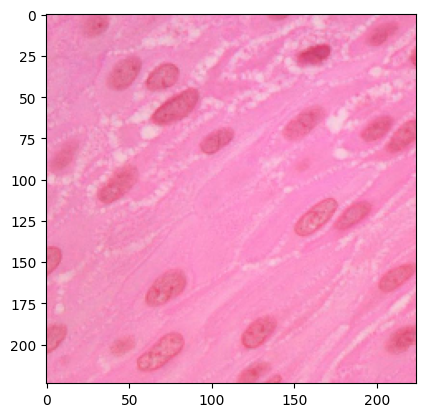

In [12]:
plt.imshow(new_array)

In [13]:
new_array.shape

(224, 224, 3)

## Create training data

In [14]:
IMG_SIZE = 224
training_data = []

def creat_train_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        labels = CATEGORIES.index(category)

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, labels])
            except Exception as e:
                pass

creat_train_data()

In [15]:
len(training_data)

15000

In [16]:
X = []
y = []

for features, labels in training_data:
    X.append(features)
    y.append(labels)


In [17]:
type(X), type(y)

(list, list)

In [18]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

In [19]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

## Deviding data for validation

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [21]:
X_train.shape, y_train.shape

((12000, 224, 224, 3), (12000,))

In [22]:
print(f'X_train length: {X_train.shape[0]}, X_train image size: {X_train.shape[1:3]}. X_train channel dimension: {X_train.shape[3]}')
print(f'X_test length: {X_test.shape[0]}, X_test image size: {X_test.shape[1:3]}. X_test channel dimension: {X_test.shape[3]}')

X_train length: 12000, X_train image size: (224, 224). X_train channel dimension: 3
X_test length: 3000, X_test image size: (224, 224). X_test channel dimension: 3


## Build the VGG model

In [23]:
from keras.applications import vgg16

In [24]:
vgg = vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape = (IMG_SIZE, IMG_SIZE, 3))

2025-11-26 14:06:39.923937: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


- we have to freeze the convolutional layers, because they are trianed to extract any kind if information from the image
- So we only have to train the dense layers of VGG16

In [25]:
# we have to freeze the convolutional layers, because they are trianed to extract any kind if information from the image
# So we only have to train the dense layers of VGG16

# Now freezing bottom layers(CNN layrs)
for layer in vgg.layers:
    layer.trainable = False

- Add top layers
- that is dense layers to train

In [26]:
model = keras.Sequential([
    vgg, 
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(3, activation='softmax'),
])

model.compile(
    optimizer = "Adam",
    loss = 'sparse_categorical_crossentropy',
    metrics = ["accuracy"]
)

history = model.fit(
    X_train,
    y_train,
    batch_size = 32,
    epochs = 2,
    validation_split = 0.2
)

Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 3331s 11s/step - accuracy: 0.8806 - loss: 0.7578 - val_accuracy: 0.9312 - val_loss: 0.1806
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 3340s 11s/step - accuracy: 0.9635 - loss: 0.0890 - val_accuracy: 0.9654 - val_loss: 0.0838


## Evaluate the model

In [ ]:
plt.figure(figsize = (10, 5))

plt.plot(history.history['accuracy'], label = "Training Accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation Accuracy")

plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.grid()
plt.show

In [ ]:
    plt.figure(figsize = (10, 5))

plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.grid()
plt.show

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Accuracy: {acc*100:.2f}")
print(f"Loss: {loss*100:.2f}")

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis = -1)

In [ ]:
# same as above code

pred = model.predict(X_test)
y_pred = [np.argmax(value) for value in pred]

In [ ]:
y_test[:5]

In [ ]:
y_pred[:5]

In [ ]:
from sklearn.metrics import classification_report

cr = classification_report(y_test, y_pred)
print(cr)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, normalize = True)
sns.heatmap(cm, cmap="crest", annot = True)
plt.xlabel("Predicted")
plt.ylabel("Actual")